# Deep Learning-Based Tweet Sentiment Classification for Hate Speech and Offensive Language Detection

## 1. Initial Setup and Library Imports

This section imports essential libraries for the tweet sentiment classification project. It includes data manipulation `pandas, numpy`, text preprocessing `nltk, re`, machine learning utilities `sklearn`, deep learning tools `tensorflow.keras`, and visualization libraries `matplotlib`,` seaborn`, `wordcloud`. These libraries enable data loading, text cleaning, tokenization, model building, training, evaluation, and visualization of results for classifying tweets as hate speech, offensive language, or neither.

In [39]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from collections import Counter
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import zipfile

In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

### 1.1 NLTK Resource Downloads

This subsection downloads essential NLTK datasets required for text preprocessing. The `punkt` dataset enables tokenization of text into words, `stopwords` provides a list of common English words to be removed, and` wordnet` supports lemmatization to reduce words to their base forms. These resources are critical for cleaning and standardizing tweet text in the preprocessing pipeline, ensuring robust input for the deep learning models.

In [41]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 1.2 Dataset Loading

In [42]:
df = pd.read_csv('/content/drive/MyDrive/Deeplearning/hatevsoffensive_language.csv')

### 1.3 Visualize Imbalance and Downsample

This section plots a bar chart to show the class imbalance in the tweet dataset for `Neither,` `Offensive,` and `Hate` labels. It then downsamples the `Offensive` class to match the smallest class size, leveling the data to make SMOTE balancing faster and more efficient. The new class counts are printed to confirm the change.

Starting imbalance:
 label
offensive language    19190
neither                4163
hate speec             1430
Name: count, dtype: int64


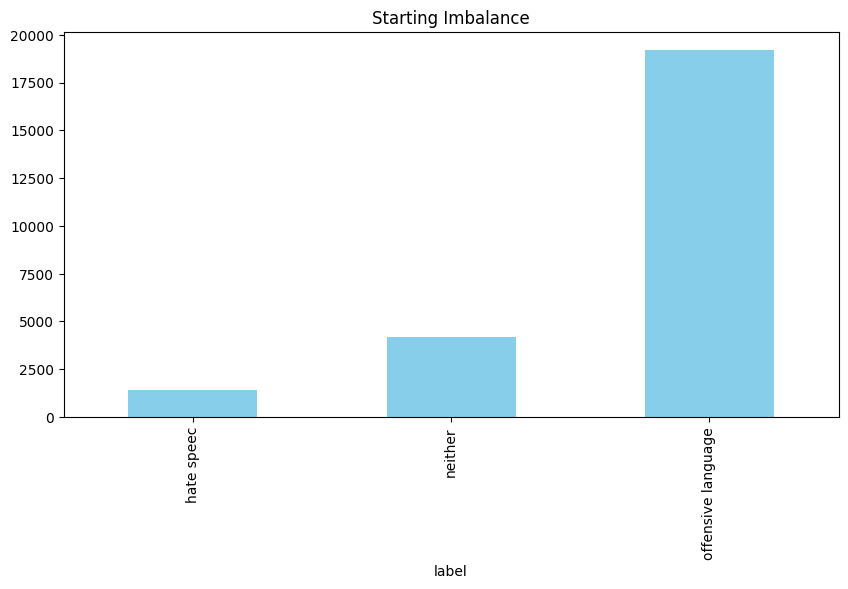

After downsampling:
 label
offensive language    5000
neither               4163
hate speec            1430
Name: count, dtype: int64


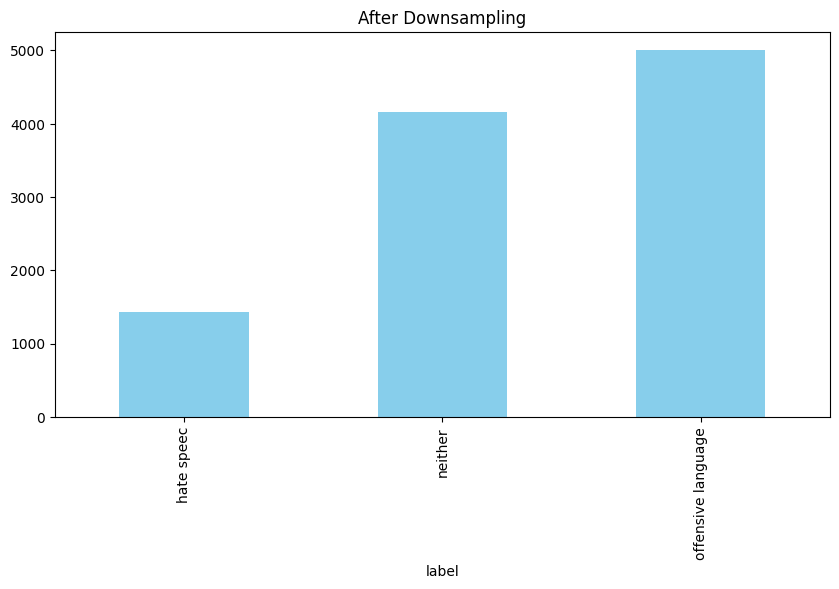

In [43]:
import pandas as pd
import matplotlib.pyplot as plt


original_counts = df['label'].value_counts()
print("Starting imbalance:\n", original_counts)

plt.figure(figsize=(10, 5))
original_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Starting Imbalance')
plt.show()

df_downsampled = df.copy()
for label, count in original_counts.items():
    if count > 5000:
        downsampled_class = resample(df[df['label'] == label], n_samples=5000, random_state=42)
        df_downsampled = pd.concat([df_downsampled[df_downsampled['label'] != label], downsampled_class])

df = df_downsampled.copy()

final_counts = df['label'].value_counts()
print("After downsampling:\n", final_counts)

plt.figure(figsize=(10, 5))
final_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('After Downsampling')
plt.show()

### 1.4 Label Mapping

This section converts the categorical labels in the tweet dataset `hate speech, offensive language, neither` into numerical values (0, 1, 2) using a dictionary `label_map`. This mapping is applied to the label column of the DataFrame, enabling the use of these labels in machine learning models, which require numerical inputs for training and evaluation.

In [44]:
label_map = {'hate speec': 0, 'offensive language': 1, 'neither': 2}
df['label'] = df['label'].map(label_map)


### 1.5 Text Preprocessing Function

This section defines a `preprocess_text` function to clean and standardize tweet text for machine learning. It converts text to lowercase, removes URLs, mentions, hashtags, numbers, and special characters, expands basic contractions (e.g., "dont" to "do not"), tokenizes the text, removes stopwords, and lemmatizes words to their base form. The processed text is joined back into a string, preparing it for tokenization and model training.


In [45]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\brt\b", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    contractions = {"dont": "do not", "cant": "cannot", "wont": "will not", "im": "i am"}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

## 2. Data Visualization

### 2.1 Word Cloud Visualization

 This subsection creates a word cloud from the combined `cleaned_text `data using the `WordCloud` library. The word cloud visually highlights the most frequent words in the preprocessed tweets, with word size proportional to frequency, offering an intuitive overview of the dataset's key terms.

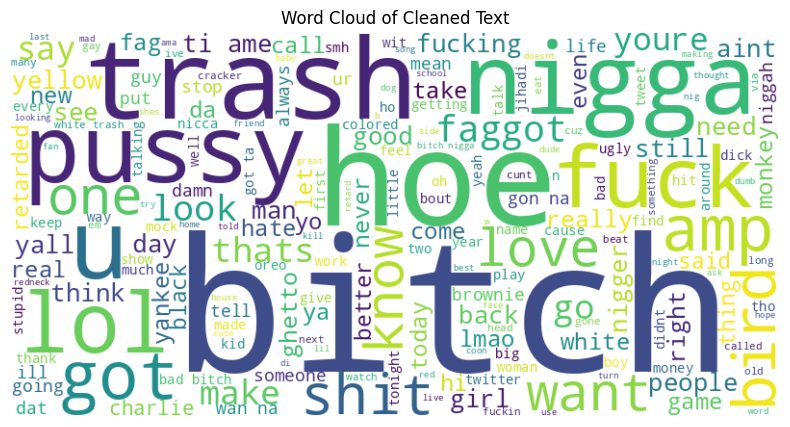

In [46]:
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()

### 2.2 Word Frequency Bar Plot

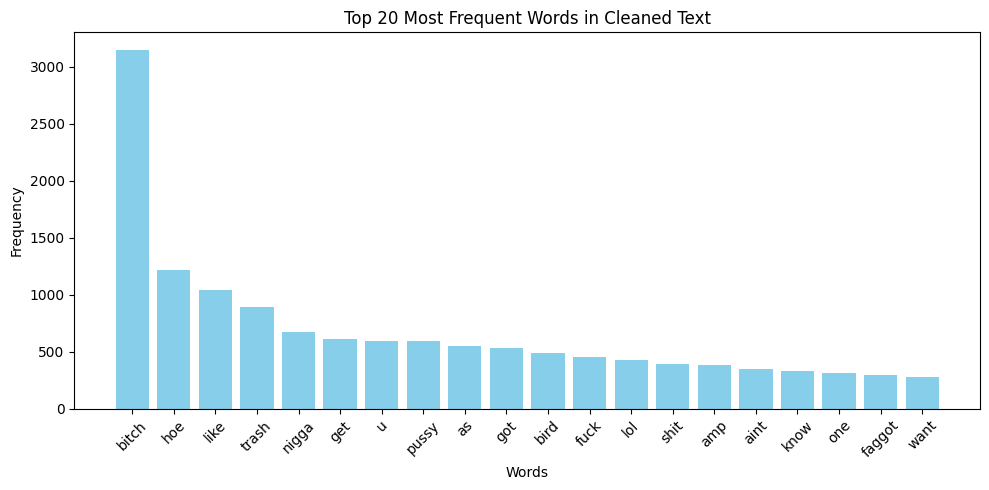

In [47]:
words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(words).most_common(20)

plt.figure(figsize=(10, 5))
plt.bar([x[0] for x in word_freq], [x[1] for x in word_freq], color='skyblue')
plt.title('Top 20 Most Frequent Words in Cleaned Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.3 Class-Specific Word Clouds

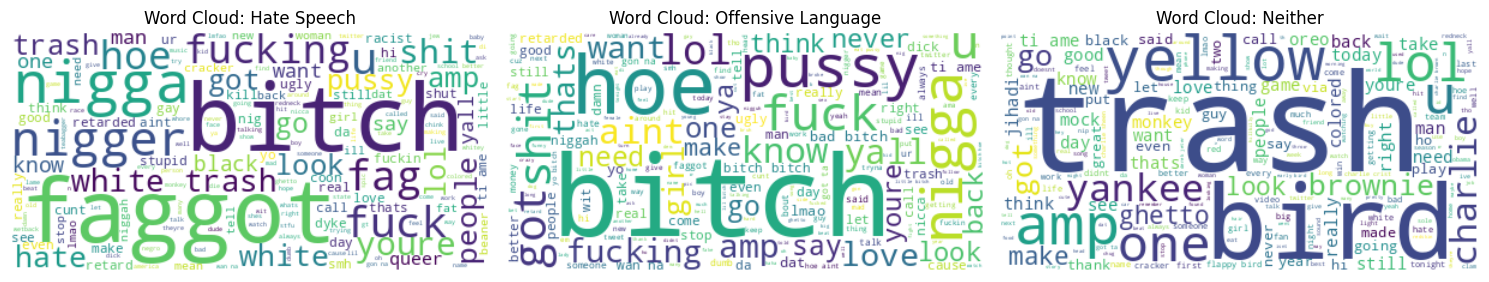

In [48]:
plt.figure(figsize=(15, 5))
for i, label in enumerate(['Hate Speech', 'Offensive Language', 'Neither']):
    class_text = ' '.join(df[df['label'] == i]['cleaned_text'])
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(class_text)
    plt.subplot(1, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {label}')
plt.tight_layout()
plt.show()

### 2.4 Text Length Distribution

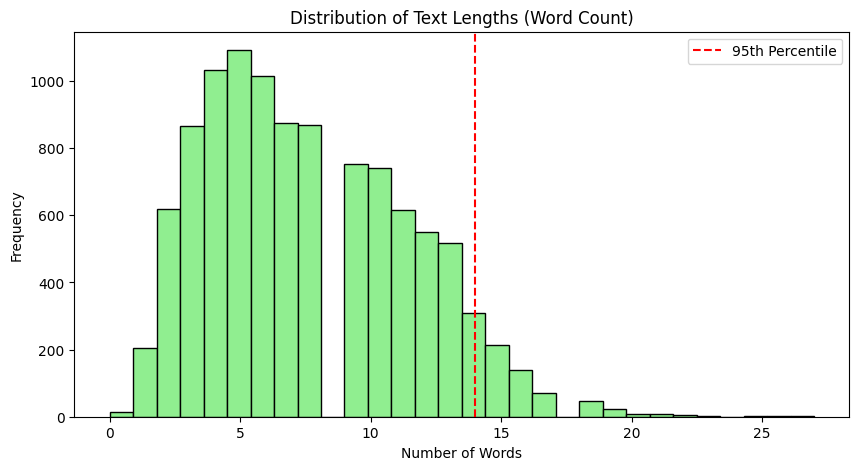

95th percentile of text length: 14 words


In [49]:
text_lengths = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Text Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(x=int(np.percentile(text_lengths, 95)), color='red', linestyle='--',
            label='95th Percentile')
plt.legend()
plt.show()
print(f"95th percentile of text length: {int(np.percentile(text_lengths, 95))} words")

## 3. Tokenization and Padding

### 3.1 Dataset Balancing with SMOTE

Description: This section addresses class imbalance in the tweet dataset by applying SMOTE (Synthetic Minority Oversampling Technique). It converts the preprocessed text (cleaned_text) into TF-IDF features, uses SMOTE to generate synthetic samples for minority classes, and maps these samples back to the most similar original texts using parallelized cosine similarity computations with joblib. The resulting balanced DataFrame ensures equal representation of classes (hate speech, offensive language, neither), verified by printing the class distribution.

In [50]:
!pip install -q imbalanced-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
import numpy as np
import pandas as pd


# SMOTE balancing
def compute_nearest_text(i, tfidf_vec, X_tfidf, X_text):
    similarities = cosine_similarity(tfidf_vec, X_tfidf)
    return X_text[np.argmax(similarities)]

X_text = df['cleaned_text'].values
y = df['label'].values
tfidf = TfidfVectorizer(max_features=500)  # Reduced for efficiency
X_tfidf = tfidf.fit_transform(X_text).toarray()
smote = SMOTE(random_state=42)
X_tfidf_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Sequential loop instead of parallel
X_text_resampled = list(X_text)
synthetic_indices = range(len(X_text), len(X_tfidf_resampled))
synthetic_tfidf = X_tfidf_resampled[len(X_text):]
for i in synthetic_indices:
    nearest = compute_nearest_text(i, synthetic_tfidf[i - len(X_text):i - len(X_text) + 1],
                                   X_tfidf[:len(X_text)], X_text)
    X_text_resampled.append(nearest)

# Create balanced DataFrame
df = pd.DataFrame({'cleaned_text': X_text_resampled, 'label': y_resampled})
print("Balanced class distribution:\n", df['label'].value_counts())

Balanced class distribution:
 label
2    5000
0    5000
1    5000
Name: count, dtype: int64


### 3.2 Tokenization and Data Splitting


This section splits the preprocessed tweet dataset into training (80%) and testing (20%) sets using train_test_split. It prepares the cleaned_text (X) and label (y) columns for tokenization and padding, ensuring the data is ready for model training and evaluation.


In [51]:
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Text Tokenization
This section tokenizes the preprocessed text from the training and testing sets using a Tokenizer from TensorFlow. The fit_on_texts method builds the vocabulary based on the training data (X_train), and texts_to_sequences converts both X_train and X_test into sequences of integers, preparing the data for padding and model input.

In [52]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### 3.3 Calculate Padding Length


This section calculates the padding length for sequences by finding the `95th percentile` of sequence lengths in the tokenized training data (X_train_seq). It ensures most sequences fit within the chosen length (max_len), balancing efficiency and data retention for the padding step. The result is printed for confirmation.

In [53]:
sequence_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(sequence_lengths, 95))
print(f"Maximum sequence length (95th percentile): {max_len}")

Maximum sequence length (95th percentile): 15


### 3.4 Apply Sequence Padding


This section pads the tokenized sequences for training (X_train_seq) and testing (X_test_seq) to a uniform length using pad_sequences with the 95th percentile length (max_len). Padding is applied at the end (padding='post'), ensuring all sequences are the same length for input into the deep learning model.

In [54]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

### 3.5 Set Vocabulary Size and Embedding Dimension


This section calculates the vocabulary size (vocab_size) by counting the unique words in the Tokenizer’s word index and adding 1 for the padding token. It also sets the embedding_dim to 50, defining the size of the word embeddings for the model’s embedding layer. These values prepare the model for training with the padded sequences.

In [55]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

### 3.6 Load GloVe Embeddings

This section defines a `load_glove_embeddings` function to load pre-trained GloVe word embeddings from a specified file path. It reads the file line by line, splits each line into a word and its corresponding vector coefficients, and stores them in a dictionary `embeddings_index`. The function returns this dictionary for use in initializing the model’s embedding layer with pre-trained weights.

In [56]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


### 3.7 Download and Load GloVe Embeddings

This section downloads the pre-trained GloVe word embeddings (6B tokens, 50 dimensions) from a Stanford NLP URL using wget and extracts the zip file with unzip. It then specifies the path to the extracted GloVe file (glove.6B.50d.txt) and uses the load_glove_embeddings function to load the embeddings into a dictionary (embeddings_index). The total number of loaded word vectors is printed for verification.

In [57]:
import os
from google.colab import drive
import zipfile
import numpy as np

glove_dir = '/content/drive/MyDrive/Deeplearning'
glove_zip_path = os.path.join(glove_dir, 'glove.6B.zip')
glove_file_path = os.path.join(glove_dir, 'glove.6B.50d.txt')

if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

if not os.path.exists(glove_file_path):
    print("GloVe file not found in Drive. Downloading...")

    !wget http://nlp.stanford.edu/data/glove.6B.zip -P {glove_dir}

    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

    print("GloVe embeddings downloaded and extracted to Drive.")
else:
    print("GloVe file already exists in Drive. Skipping download.")

embeddings_index = load_glove_embeddings(glove_file_path)
print(f"Loaded {len(embeddings_index)} GloVe word vectors.")

GloVe file already exists in Drive. Skipping download.
Loaded 400000 GloVe word vectors.


### 3.8 Create Embedding Matrix
This section builds an embedding matrix for the model by creating a zero-initialized matrix of shape (vocab_size, embedding_dim). It then maps each word in the Tokenizer’s vocabulary to its pre-trained GloVe embedding from embeddings_index. If a word has a GloVe vector, it’s added to the matrix at the corresponding index; otherwise, the row remains zeros. This matrix will be used to initialize the model’s embedding layer with pre-trained weights.

In [58]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


## 4. Model Building and Training

### 4.1 Simple RNN Model with Trainable Embedding Layer

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(3, activation='softmax')
])

rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

rnn_model.build(input_shape=(None, max_len))

rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 15, 50)         │       552,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,165 (2.15 MB)

 Trainable params: 564,165 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rnn = rnn_model.fit(X_train_pad, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_test_pad, y_test),
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.4870 - loss: 0.9767 - val_accuracy: 0.8230 - val_loss: 0.4580
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8695 - loss: 0.3971 - val_accuracy: 0.8690 - val_loss: 0.3850
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9328 - loss: 0.2278 - val_accuracy: 0.8807 - val_loss: 0.3510
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9508 - loss: 0.1692 - val_accuracy: 0.9043 - val_loss: 0.3251
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9617 - loss: 0.1312 - val_accuracy: 0.8810 - val_loss: 0.4207
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9713 - loss: 0.1052 - val_accuracy: 0.8990 - val_loss: 0.4546
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9735 - loss: 0.0994 - val_accuracy: 0.9067 - val_loss: 0.3758
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9754 - loss: 0.0864 - val_ac

#### 4.1.1 Evaluate Simple RNN Model
Description: This subsection evaluates the trained Simple RNN model on the test set, plotting training vs. validation loss and accuracy over epochs using matplotlib. It calculates test accuracy, visualizes a confusion matrix with a heatmap using seaborn, and prints a classification report with precision, recall, and F1-score for each class (hate speech, offensive language, neither).

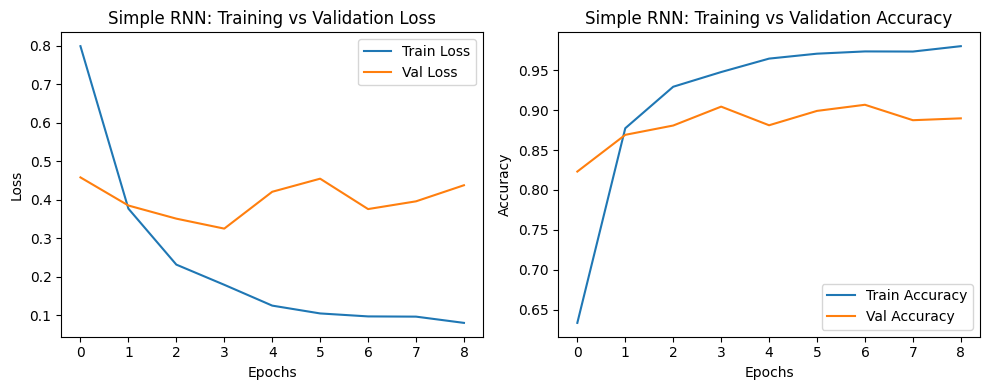

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Simple RNN Accuracy: 0.9043


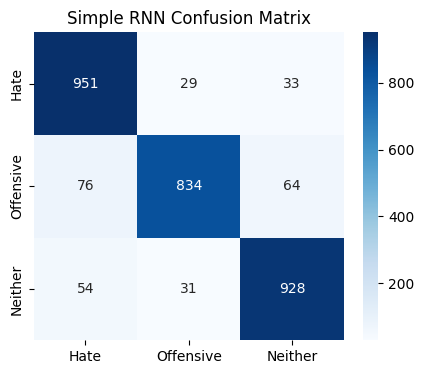

Simple RNN Classification Report:

              precision    recall  f1-score   support

        Hate       0.88      0.94      0.91      1013
   Offensive       0.93      0.86      0.89       974
     Neither       0.91      0.92      0.91      1013

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Visualize training performance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Simple RNN: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Simple RNN: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
y_pred_rnn = rnn_model.predict(X_test_pad).argmax(axis=1)
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
print(f"Simple RNN Accuracy: {accuracy_rnn:.4f}")

cm_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate', 'Offensive', 'Neither'],
            yticklabels=['Hate', 'Offensive', 'Neither'])
plt.title('Simple RNN Confusion Matrix')
plt.show()

print("Simple RNN Classification Report:\n")
print(classification_report(y_test, y_pred_rnn, target_names=['Hate', 'Offensive', 'Neither']))

In [62]:
import json
model_save_path = '/content/drive/MyDrive/Deeplearning/rnn_model.keras'
history_save_path = '/content/drive/MyDrive/Deeplearning/rnn_history.json'

# Save the trained model
rnn_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the training history
history_dict = {key: [float(val) for val in values] for key, values in history_rnn.history.items()}
with open(history_save_path, 'w') as f:
    json.dump(history_dict, f)
print(f"Training history saved to {history_save_path}")

Model saved to /content/drive/MyDrive/Deeplearning/rnn_model.keras
Training history saved to /content/drive/MyDrive/Deeplearning/rnn_history.json


### 4.2 LSTM Model with Trainable Embedding Layer
This subsection builds an LSTM model with a trainable Embedding layer, an LSTM layer with 64 units, dropout for regularization, and a Dense output layer for 3-class classification (hate speech, offensive language, neither). The model is compiled and prepared for training.

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False, kernel_regularizer='l2'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_model.build(input_shape=(None, max_len))

lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 15, 50)         │       552,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,317 (2.49 MB)

 Trainable params: 652,933 (2.49 MB)

 Non-trainable params: 384 (1.50 KB)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

history_lstm = lstm_model.fit(X_train_pad, y_train,
                              epochs=30,
                              batch_size=32,
                              validation_data=(X_test_pad, y_test),
                              callbacks=[early_stopping], verbose=1)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.3322 - loss: 2.7742 - val_accuracy: 0.5170 - val_loss: 1.6889
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5886 - loss: 1.5678 - val_accuracy: 0.7133 - val_loss: 1.1607
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.7828 - loss: 1.0217 - val_accuracy: 0.8200 - val_loss: 0.7927
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8817 - loss: 0.6655 - val_accuracy: 0.8387 - val_loss: 0.6273
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9091 - loss: 0.4735 - val_accuracy: 0.8780 - val_loss: 0.4863
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9176 - loss: 0.3849 - val_accuracy: 0.8120 - val_loss: 0.5877
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9271 - loss: 0.3162 - val_accuracy: 0.8747 - val_loss: 0.4245
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9358 - loss: 0.2602 - 

In [65]:
model_save_path = '/content/drive/MyDrive/Deeplearning/lstm_model.keras'
history_save_path = '/content/drive/MyDrive/Deeplearning/lstm_history.json'
lstm_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

history_dict = {key: [float(val) for val in values] for key, values in history_lstm.history.items()}
with open(history_save_path, 'w') as f:
    json.dump(history_dict, f)
print(f"Training history saved to {history_save_path}")

Model saved to /content/drive/MyDrive/Deeplearning/lstm_model.keras
Training history saved to /content/drive/MyDrive/Deeplearning/lstm_history.json


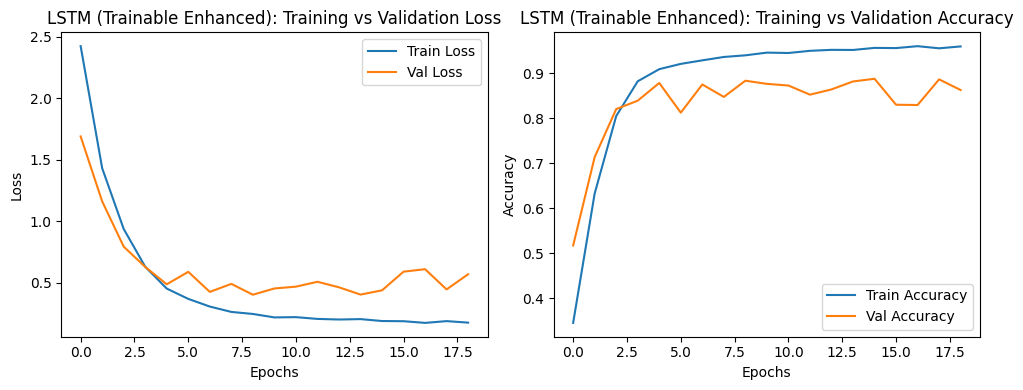

In [66]:
import matplotlib.pyplot as plt

# Visualize training performance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM (Trainable Enhanced): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM (Trainable Enhanced): Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM (Trainable Enhanced) Accuracy: 0.8830


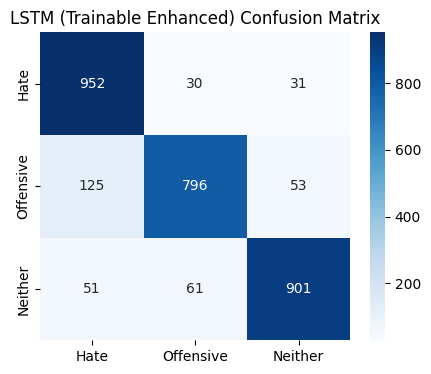

LSTM (Trainable Enhanced) Classification Report:

              precision    recall  f1-score   support

        Hate       0.84      0.94      0.89      1013
   Offensive       0.90      0.82      0.86       974
     Neither       0.91      0.89      0.90      1013

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.89      0.88      0.88      3000



In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_pad).argmax(axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM (Trainable Enhanced) Accuracy: {accuracy_lstm:.4f}")

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate', 'Offensive', 'Neither'],
            yticklabels=['Hate', 'Offensive', 'Neither'])
plt.title('LSTM (Trainable Enhanced) Confusion Matrix')
plt.show()

print("LSTM (Trainable Enhanced) Classification Report:\n")
print(classification_report(y_test, y_pred_lstm, target_names=['Hate', 'Offensive', 'Neither']))

### 4.3 Build Enhanced LSTM Model with Pre-trained GloVe Embeddings
This subsection constructs an enhanced LSTM model using pre-trained GloVe embeddings loaded from Google Drive, with trainable weights, an LSTM layer with 128 units, dropout and batch normalization, and additional dense layers for 3-class classification.



In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from google.colab import drive
import numpy as np


# Load GloVe embeddings from Drive
embeddings_index = {}
glove_path = '/content/drive/MyDrive/Deeplearning/glove.6B.50d.txt'
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build enhanced LSTM model with pre-trained GloVe embeddings
lstm_glove_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=True),
    Dropout(0.5),
    LSTM(128, return_sequences=False, kernel_regularizer='l2'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')  # Adjusted for 3-class classification
])

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.001)
lstm_glove_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Build the model to display summary
lstm_glove_model.build(input_shape=(None, max_len))

# Display the model summary
lstm_glove_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 15, 50)         │       552,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,317 (2.49 MB)

 Trainable params: 652,933 (2.49 MB)

 Non-trainable params: 384 (1.50 KB)

#### 4.3.1 Train and Save Enhanced LSTM Model with Pre-trained GloVe Embeddings
This subsection trains the enhanced LSTM model with pre-trained GloVe embeddings using early stopping and a learning rate scheduler, then saves the trained model and its training history to Google Drive.

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import time

# Learning rate scheduler (exponential decay)
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * np.exp(-decay_rate)
    return lr

# Train the model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(lr_scheduler)
]

start = time.time()
history_glove = lstm_glove_model.fit(X_train_pad, y_train,
                                     epochs=30,
                                     batch_size=32,
                                     validation_data=(X_test_pad, y_test),
                                     callbacks=callbacks, verbose=1)
print(f"LSTM + GloVe Enhanced training time: {time.time() - start:.2f} seconds")

# Save the model and history
model_save_path = '/content/drive/MyDrive/Deeplearning/lstm_glove_model_enhanced_v2.keras'
history_save_path = '/content/drive/MyDrive/Deeplearning/lstm_glove_history_enhanced_v2.json'
lstm_glove_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

history_dict = {key: [float(val) for val in values] for key, values in history_glove.history.items()}
with open(history_save_path, 'w') as f:
    json.dump(history_dict, f)
print(f"Training history saved to {history_save_path}")

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.4655 - loss: 2.5553 - val_accuracy: 0.7260 - val_loss: 1.3227 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6635 - loss: 1.2935 - val_accuracy: 0.7760 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.7333 - loss: 0.8844 - val_accuracy: 0.8053 - val_loss: 0.6441 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.7673 - loss: 0.6993 - val_accuracy: 0.8303 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.7957 - loss: 0.6143 - val_accuracy: 0.8393 - val_loss: 0.4883 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.8206 - loss: 0.5434 - val_accuracy: 0.8513 - val_loss: 0.4587 - learning_rate: 9.0484e-04
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8228

#### 4.3.2 Visualize Training Performance of Enhanced LSTM Model with Pre-trained GloVe Embeddings
This subsection plots the training vs. validation loss and accuracy over epochs for the enhanced LSTM model with pre-trained GloVe embeddings to assess training stability

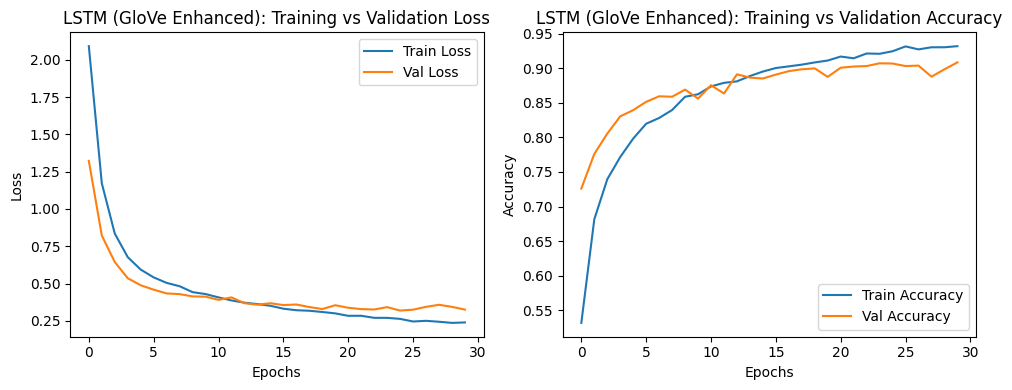

In [70]:
import matplotlib.pyplot as plt

# Visualize training performance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_glove.history['loss'], label='Train Loss')
plt.plot(history_glove.history['val_loss'], label='Val Loss')
plt.title('LSTM (GloVe Enhanced): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_glove.history['accuracy'], label='Train Accuracy')
plt.plot(history_glove.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM (GloVe Enhanced): Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### 4.3.3 Evaluate Enhanced LSTM Model with Pre-trained GloVe Embeddings
This subsection evaluates the enhanced LSTM model with pre-trained GloVe embeddings on the test set, providing accuracy, a confusion matrix heatmap, and a classification report.

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM (GloVe Enhanced) Accuracy: 0.9067


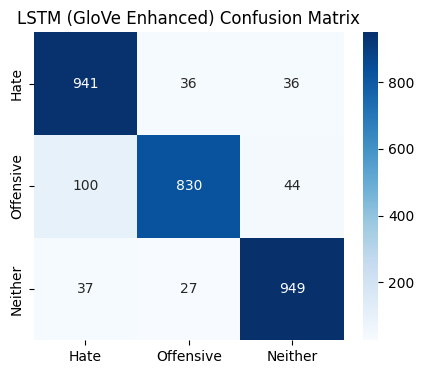

LSTM (GloVe Enhanced) Classification Report:

              precision    recall  f1-score   support

        Hate       0.87      0.93      0.90      1013
   Offensive       0.93      0.85      0.89       974
     Neither       0.92      0.94      0.93      1013

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [71]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model
y_pred_glove = lstm_glove_model.predict(X_test_pad).argmax(axis=1)
accuracy_glove = accuracy_score(y_test, y_pred_glove)
print(f"LSTM (GloVe Enhanced) Accuracy: {accuracy_glove:.4f}")

cm_glove = confusion_matrix(y_test, y_pred_glove)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate', 'Offensive', 'Neither'],
            yticklabels=['Hate', 'Offensive', 'Neither'])
plt.title('LSTM (GloVe Enhanced) Confusion Matrix')
plt.show()

print("LSTM (GloVe Enhanced) Classification Report:\n")
print(classification_report(y_test, y_pred_glove, target_names=['Hate', 'Offensive', 'Neither']))

## 6. Model Comparison and Visualization

### 6.1 Visualize Training and Validation Curves for All Models
This subsection plots the training and validation accuracy and loss curves for the Simple RNN, Enhanced LSTM with Trainable Embeddings, and Enhanced LSTM with Pre-trained GloVe Embeddings on the same graphs to compare their performance over epochs.

In [4]:
import json
from google.colab import drive

# Paths to histories
base_path = '/content/drive/MyDrive/Deeplearning/'
rnn_history_path = base_path + 'rnn_history.json'
lstm_history_path = base_path + 'lstm_history.json'
glove_history_path = base_path + 'lstm_glove_history_enhanced_v2.json'

# Load histories
with open(rnn_history_path, 'r') as f:
    history_rnn = json.load(f)
with open(lstm_history_path, 'r') as f:
    history_lstm = json.load(f)
with open(glove_history_path, 'r') as f:
    history_glove = json.load(f)

print("Histories loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Histories loaded successfully!


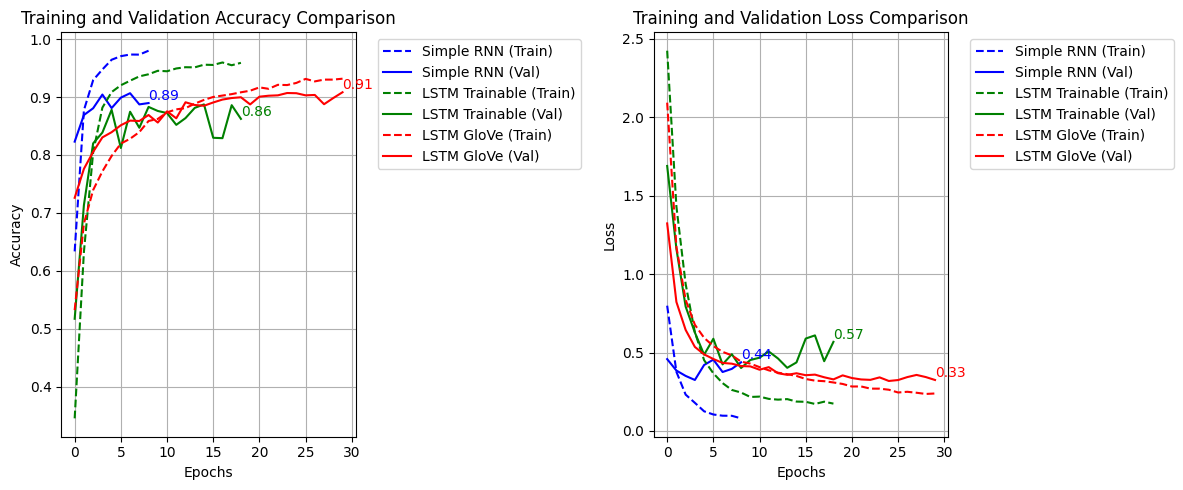

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn['accuracy'], label='Simple RNN (Train)', color='blue', linestyle='--')
plt.plot(history_rnn['val_accuracy'], label='Simple RNN (Val)', color='blue')
plt.plot(history_lstm['accuracy'], label='LSTM Trainable (Train)', color='green', linestyle='--')
plt.plot(history_lstm['val_accuracy'], label='LSTM Trainable (Val)', color='green')
plt.plot(history_glove['accuracy'], label='LSTM GloVe (Train)', color='red', linestyle='--')
plt.plot(history_glove['val_accuracy'], label='LSTM GloVe (Val)', color='red')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

last_rnn = len(history_rnn['accuracy']) - 1
last_lstm = len(history_lstm['accuracy']) - 1
last_glove = len(history_glove['accuracy']) - 1
plt.text(last_rnn, history_rnn['val_accuracy'][-1], f'{history_rnn["val_accuracy"][-1]:.2f}', ha='left', va='bottom', color='blue')
plt.text(last_lstm, history_lstm['val_accuracy'][-1], f'{history_lstm["val_accuracy"][-1]:.2f}', ha='left', va='bottom', color='green')
plt.text(last_glove, history_glove['val_accuracy'][-1], f'{history_glove["val_accuracy"][-1]:.2f}', ha='left', va='bottom', color='red')

plt.subplot(1, 2, 2)
plt.plot(history_rnn['loss'], label='Simple RNN (Train)', color='blue', linestyle='--')
plt.plot(history_rnn['val_loss'], label='Simple RNN (Val)', color='blue')
plt.plot(history_lstm['loss'], label='LSTM Trainable (Train)', color='green', linestyle='--')
plt.plot(history_lstm['val_loss'], label='LSTM Trainable (Val)', color='green')
plt.plot(history_glove['loss'], label='LSTM GloVe (Train)', color='red', linestyle='--')
plt.plot(history_glove['val_loss'], label='LSTM GloVe (Val)', color='red')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.text(last_rnn, history_rnn['val_loss'][-1], f'{history_rnn["val_loss"][-1]:.2f}', ha='left', va='bottom', color='blue')
plt.text(last_lstm, history_lstm['val_loss'][-1], f'{history_lstm["val_loss"][-1]:.2f}', ha='left', va='bottom', color='green')
plt.text(last_glove, history_glove['val_loss'][-1], f'{history_glove["val_loss"][-1]:.2f}', ha='left', va='bottom', color='red')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deeplearning/all_models_comparison_curves_final.png')
plt.show()

### 6.2 Compare Test Accuracies with a Bar Chart
This subsection creates a bar chart comparing the test accuracies of the three models, providing a clear visual representation of their performance on the test set.

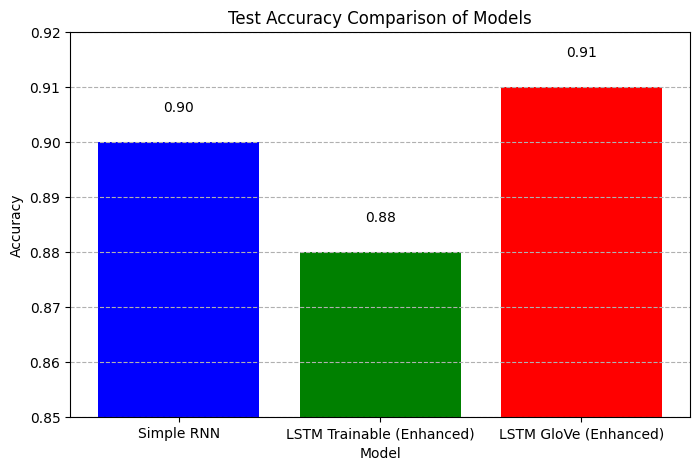

In [6]:
import matplotlib.pyplot as plt

# Corrected test accuracies from classification reports
accuracies = {
    'Simple RNN': 0.90,
    'LSTM Trainable (Enhanced)': 0.88,
    'LSTM GloVe (Enhanced)': 0.91
}

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.title('Test Accuracy Comparison of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.85, 0.92)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005, f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.grid(True, axis='y', linestyle='--')
plt.savefig('/content/drive/MyDrive/Deeplearning/all_models_accuracy_bar_corrected.png')
plt.show()

### 6.3 Summary Table of Model Performance
This subsection creates a table summarizing key metrics (test accuracy, F1-scores for each class) for all three models, which can be converted into a visual table for LinkedIn using a markdown or LaTeX format.

In [8]:
from tabulate import tabulate

table_data = [
    ['Simple RNN', 0.90, 0.91, 0.89, 0.91],
    ['LSTM Trainable (Enhanced)', 0.88, 0.89, 0.86, 0.90],
    ['LSTM GloVe (Enhanced)', 0.91, 0.91, 0.89, 0.93]
]

headers = ['Model', 'Test Accuracy', 'F1 (Hate)', 'F1 (Offensive)', 'F1 (Neither)']
table = tabulate(table_data, headers=headers, tablefmt='grid', floatfmt='.2f')
print(table)

with open('/content/drive/MyDrive/Deeplearning/all_models_summary_table_final.txt', 'w') as f:
    f.write(table)

+---------------------------+-----------------+-------------+------------------+----------------+
| Model                     |   Test Accuracy |   F1 (Hate) |   F1 (Offensive) |   F1 (Neither) |
+===========================+=================+=============+==================+================+
| Simple RNN                |            0.90 |        0.91 |             0.89 |           0.91 |
+---------------------------+-----------------+-------------+------------------+----------------+
| LSTM Trainable (Enhanced) |            0.88 |        0.89 |             0.86 |           0.90 |
+---------------------------+-----------------+-------------+------------------+----------------+
| LSTM GloVe (Enhanced)     |            0.91 |        0.91 |             0.89 |           0.93 |
+---------------------------+-----------------+-------------+------------------+----------------+


## GUI

In [11]:
import tensorflow as tf

base_path = '/content/drive/MyDrive/Deeplearning/'
model_files = {
    'rnn': 'rnn_model.keras',
    'lstm': 'lstm_model_enhanced.keras',
    'glove': 'lstm_glove_model_enhanced_v2.keras'
}

models = {}
for model_name, file_name in model_files.items():
    try:
        models[model_name] = tf.keras.models.load_model(base_path + file_name)
        print(f"Successfully loaded {model_name} model from {file_name}")
    except Exception as e:
        print(f"Error loading {model_name} model from {file_name}: {e}")

import os
print("Available files in Deeplearning folder:", os.listdir(base_path))

Mounted at /content/drive
Successfully loaded rnn model from rnn_model.keras
Error loading lstm model from lstm_model_enhanced.keras: File not found: filepath=/content/drive/MyDrive/Deeplearning/lstm_model_enhanced.keras. Please ensure the file is an accessible `.keras` zip file.
Successfully loaded glove model from lstm_glove_model_enhanced_v2.keras
Available files in Deeplearning folder: ['glove.6B.zip', 'archive.zip', 'Brain_tumer_mri_data', 'glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'hatevsoffensive_language.csv', 'rnn_model.keras', 'rnn_history.json', 'lstm_model.keras', 'lstm_history.json', 'lstm_glove_model_enhanced_v2.keras', 'lstm_glove_history_enhanced_v2.json', 'model_accuracy_bar_updated.png', 'model_summary_table_updated.txt', 'simple_rnn_curves.png', 'lstm_trainable_curves.png', 'lstm_glove_enhanced_curves.png', 'all_models_comparison_curves_final.png', 'all_models_accuracy_bar_corrected.png', 'all_models_summary_table_final.txt', '

In [13]:
!pip install gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
import pandas as pd

base_path = '/content/drive/MyDrive/Deeplearning/'
models = {
    'Simple RNN': tf.keras.models.load_model(base_path + 'rnn_model.keras'),
    'LSTM Trainable': tf.keras.models.load_model(base_path + 'lstm_model.keras'),
    'LSTM GloVe': tf.keras.models.load_model(base_path + 'lstm_glove_model_enhanced_v2.keras')
}
print("All models loaded successfully!")

data = pd.read_csv(base_path + 'hatevsoffensive_language.csv')
texts = data['text'].values

max_len = 100
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

def predict_text(model_name, text):
    if not text:
        return "Please enter some text!"

    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=max_len)

    model = models[model_name]

    prediction = model.predict(padded, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_labels = ['Hate', 'Offensive', 'Neither']
    return f"Prediction: {class_labels[predicted_class]}"

interface = gr.Interface(
    fn=predict_text,
    inputs=[
        gr.Dropdown(choices=list(models.keys()), label="Select Model", value="Simple RNN"),
        gr.Textbox(lines=3, placeholder="Enter text to classify (e.g., 'I hate this!' or 'This is fine')", label="Input Text")
    ],
    outputs=gr.Textbox(label="Prediction Result"),
    title="Text Classification Predictor",
    description="Pick a model and type some text to classify it as Hate, Offensive, or Neither. Built with ❤️ for NLP enthusiasts!",
    theme="huggingface",
    css="""
        .gradio-container {
            max-width: 900px;
            margin: 0 auto;
            padding: 30px;
            background-color: #f0f4f8;
            border-radius: 15px;
            box-shadow: 0 0 20px rgba(0,0,0,0.1);
        }
        .gr-button {
            background-color: #ff6b6b;
            color: white;
            padding: 12px 25px;
            border: none;
            border-radius: 8px;
            cursor: pointer;
            font-size: 16px;
        }
        .gr-button:hover {
            background-color: #ff8787;
        }
        h1 {
            color: #1e3a8a;
            font-size: 2.8em;
            margin-bottom: 20px;
        }
        .gr-input label, .gr-output label {
            font-size: 1.2em;
            color: #2c3e50;
        }
    """
)

interface.launch(debug=True)

Mounted at /content/drive
All models loaded successfully!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1153: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-6837586e-7e5adc8d62e81adf11bdc397;9b50629c-fb3f-4450-b3ed-e999d1fa14b7)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://17eccc95219eece1d9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://17eccc95219eece1d9.gradio.live
